Note: This was originally a take-home project with a time frame of 3 hours

In this notebook, we are tasked with attempting to correctly predict/classify the direction of Amazon's stock price, and to specifically maximize the AUC metric with a goal of AUC > 0.515. The data has already been split into training, validation, and test sets.

In [68]:
# Bread and Butter Libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import RocCurveDisplay


# Classifiers
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier as RF, GradientBoostingClassifier as GB)
from sklearn.svm import SVC

print('Done')

Done


Exploration Phase

In [69]:
df_train = pd.read_csv('train_amazon.csv')

In [70]:
df_train.shape

(4781, 7)

In [71]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4781 entries, 0 to 4780
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4781 non-null   object 
 1   Open       4781 non-null   float64
 2   High       4781 non-null   float64
 3   Low        4781 non-null   float64
 4   Close      4781 non-null   float64
 5   Adj Close  4781 non-null   float64
 6   Volume     4781 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 261.6+ KB


In [72]:
df_train.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4781.000000,4781.000000,4781.000000,4781.000000,4781.000000,4.781000e+03
mean,127.619845,129.480122,125.697925,127.662449,127.662449,8.225935e+06
std,145.693083,147.132537,144.053633,145.677581,145.677581,7.810188e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,34.299999,34.849998,33.660000,34.310001,34.310001,4.200900e+06
50%,62.880001,64.750000,60.937500,62.750000,62.750000,6.200100e+06
75%,189.009995,191.600006,186.210007,189.029999,189.029999,9.239900e+06
max,717.380005,722.450012,711.510010,717.929993,717.929993,1.043292e+08


In [73]:
df_train['Date'].describe()

count           4781
unique          4781
top       1997-05-15
freq               1
Name: Date, dtype: object

In [74]:
# Find the date range
df_train["Date"].min(), df_train["Date"].max()

('1997-05-15', '2016-05-13')

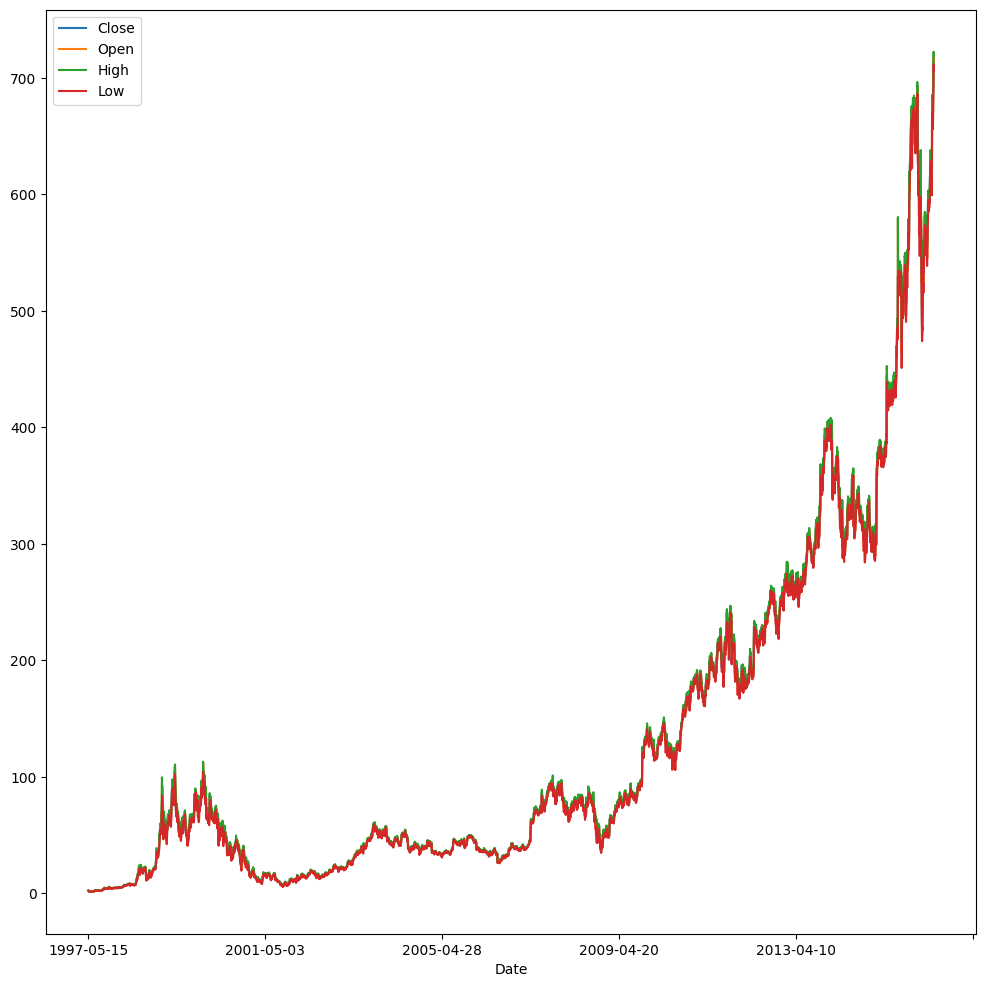

In [75]:
# Plot the Dataframe
plt.rcParams["figure.figsize"] = (12,12)
pl1 = df_train.plot(x="Date", y=["Close", "Open", "High", "Low"])

In [76]:
# Make a quick function to repeat the previous exploration with the validation and test sets
def explore(dataframe):
    """Runs an exploration analysis of the dataframe."""
    print("Shape", dataframe.shape, "\n")
    print("Columns", dataframe.columns, "\n")
    dataframe.info()
    print("\n", dataframe.describe(), "\n")
    print("The data ranges from", dataframe["Date"].min(), "to", dataframe["Date"].max())
    dataframe.plot(x="Date", y=["Close", "Open", "High", "Low"])

Shape (503, 7) 

Columns Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       503 non-null    object 
 1   Open       503 non-null    float64
 2   High       503 non-null    float64
 3   Low        503 non-null    float64
 4   Close      503 non-null    float64
 5   Adj Close  503 non-null    float64
 6   Volume     503 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 27.6+ KB

               Open         High  ...    Adj Close        Volume
count   503.000000   503.000000  ...   503.000000  5.030000e+02
mean    992.201292   999.898131  ...   991.828966  3.918924e+06
std     255.496588   259.220381  ...   254.885469  2.069197e+06
min     689.559998   696.820007  ...   691.359985  1.458800e+06
25%     780.500000   785.625000  ... 

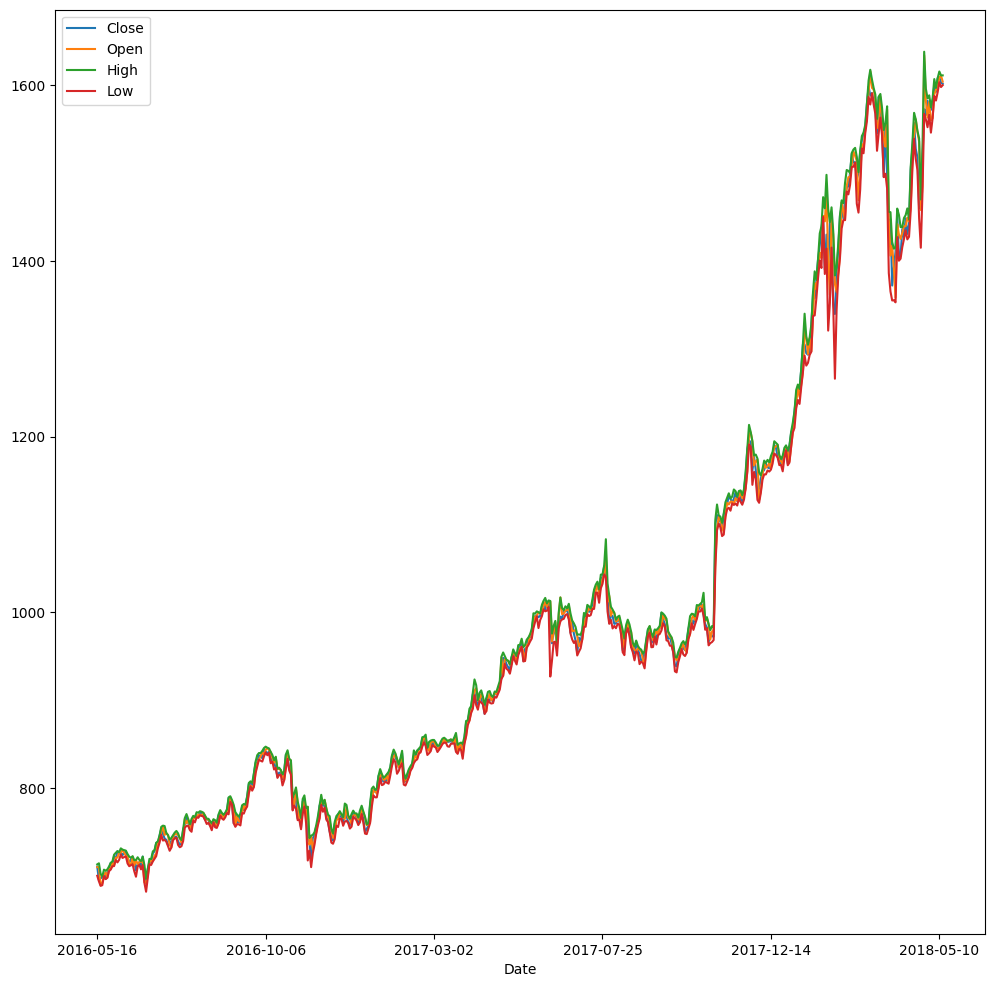

In [77]:
df_val = pd.read_csv("val_amazon.csv")
explore(df_val)

Shape

 (504, 7) 

Columns Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       504 non-null    object 
 1   Open       504 non-null    float64
 2   High       504 non-null    float64
 3   Low        504 non-null    float64
 4   Close      504 non-null    float64
 5   Adj Close  504 non-null    float64
 6   Volume     504 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 27.7+ KB

               Open         High  ...    Adj Close        Volume
count   504.000000   504.000000  ...   504.000000  5.040000e+02
mean   1823.927758  1843.069246  ...  1824.040536  4.705042e+06
std     178.129809   179.294163  ...   178.470078  2.288185e+06
min    1346.000000  1396.030029  ...  1343.959961  8.813000e+05
25%    1712.924988  1730.602447  ...  1713

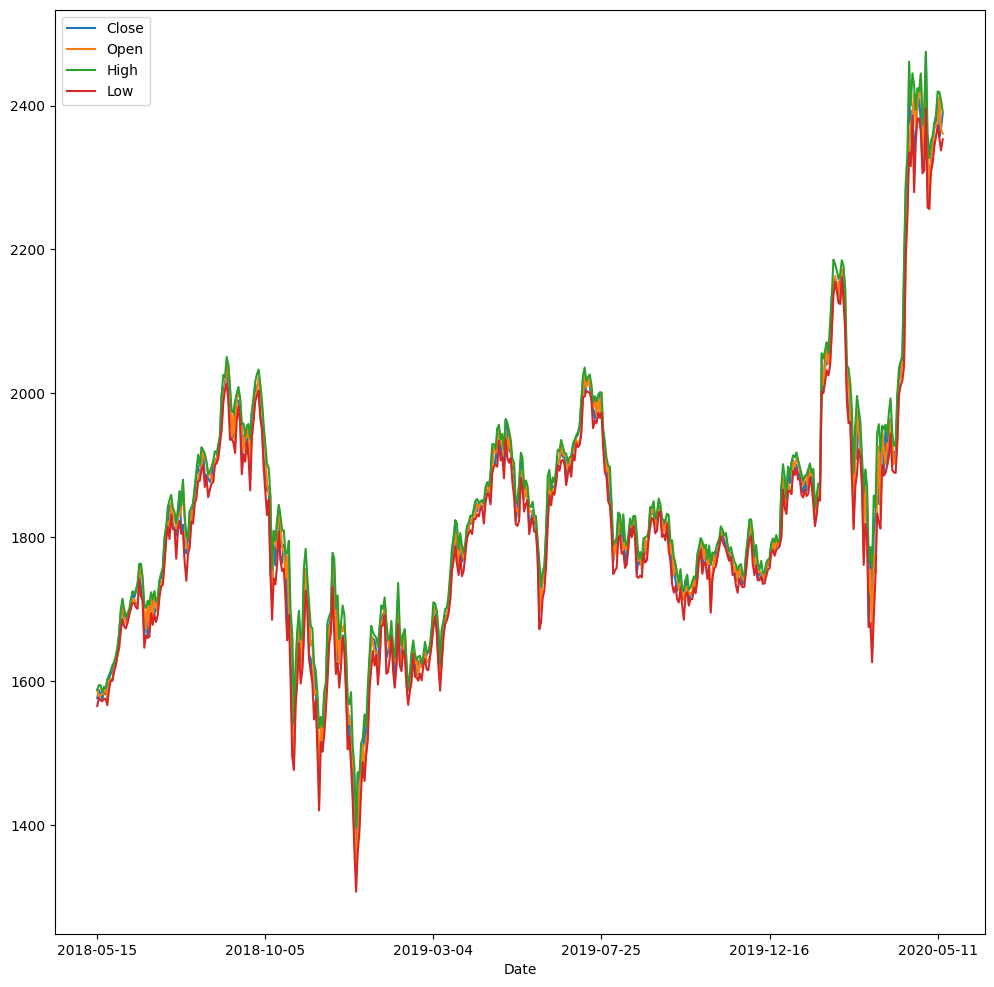

In [78]:
df_test = pd.read_csv("test_amazon.csv")
explore(df_test)

The Datatypes and underlying distributions seem consistent. Now we have to engineer the response so that we can actually predict the direction, as this is not given explicitly in the data. To do this is fairly straighforward, shift the data a day back and then compare the 'closing' and 'opening' columns.

In [79]:
# Sort the data by date
df_train.sort_values(by="Date", inplace=True)
df_val.sort_values(by="Date", inplace=True)
df_test.sort_values(by="Date", inplace=True)

In [80]:
'''
Using the pandas 'shift' method, we create the response column by comparing the prices of two days, the '-1' compares a day to the next day. We then convert the bool to an integer
value.
'''

df_train["Target"] = (df_train["Close"] > df_train["Open"]).shift(periods=-1, fill_value=0).astype(int)

In [81]:
# Ensuring it worked
df_train

,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,0
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,0
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,0
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,0
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,0
...,...,...,...,...,...,...,...,...
4776,2016-05-09,673.950012,686.979980,671.409973,679.750000,679.750000,3982200,1
4777,2016-05-10,694.000000,704.549988,693.500000,703.070007,703.070007,6105600,1
4778,2016-05-11,705.789978,719.000000,701.650024,713.229980,713.229980,7338200,1
4779,2016-05-12,717.380005,722.450012,711.510010,717.929993,717.929993,5048200,0


In [82]:
# Checking the class distribution
df_train["Target"].value_counts()

Target
1    2392
0    2389
Name: count, dtype: int64

Overall, the amount of days where the close is higher than the open (1) is about even to the latter. We repeat this process and check the distributions for the other sets

In [83]:
df_val["Target"] = (df_val["Close"] > df_val["Open"]).shift(periods=-1, fill_value=0).astype(int)
df_test["Target"] = (df_test["Close"] > df_test["Open"]).shift(periods=-1, fill_value=0).astype(int)

In [84]:
print(df_val["Target"].value_counts())
print(df_test["Target"].value_counts())

Target
0    255
1    248
Name: count, dtype: int64
Target
1    255
0    249
Name: count, dtype: int64


Feature Engineering

Want to include a moving average to features, do so with 3, 5, and 7 days

In [85]:
# 3 day moving average
df_train["Moving_Average_3"] = (df_train["Close"] - df_train["Open"]).rolling(window=3, min_periods=1).mean()
df_val["Moving_Average_3"] = (df_val["Close"] - df_val["Open"]).rolling(window=3, min_periods=1).mean()
df_test["Moving_Average_3"] = (df_test["Close"] - df_test["Open"]).rolling(window=3, min_periods=1).mean()

In [86]:
# Ensure it worked correctly
df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Target,Moving_Average_3
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,0,-0.479167
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,0,-0.359375
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,0,-0.256945
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,0,-0.128472
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,0,-0.118056


In [87]:
# Add the others
df_train["Moving_Average_5"] = (df_train["Close"] - df_train["Open"]).rolling(window=5, min_periods=1).mean()
df_val["Moving_Average_5"] = (df_val["Close"] - df_val["Open"]).rolling(window=5, min_periods=1).mean()
df_test["Moving_Average_5"] = (df_test["Close"] - df_test["Open"]).rolling(window=5, min_periods=1).mean()

df_train["Moving_Average_7"] = (df_train["Close"] - df_train["Open"]).rolling(window=7, min_periods=1).mean()
df_val["Moving_Average_7"] = (df_val["Close"] - df_val["Open"]).rolling(window=7, min_periods=1).mean()
df_test["Moving_Average_7"] = (df_test["Close"] - df_test["Open"]).rolling(window=7, min_periods=1).mean()


df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Target,Moving_Average_3,Moving_Average_5,Moving_Average_7
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,0,-0.479167,-0.479167,-0.479167
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,0,-0.359375,-0.359375,-0.359375
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,0,-0.256945,-0.256945,-0.256945
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,0,-0.128472,-0.216146,-0.216146
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,0,-0.118056,-0.214584,-0.214584


The Fluctuation/Range also might be important

In [88]:
# Price Range
df_train["Price_Range"] = df_train["High"] - df_train["Low"]
df_val["Price_Range"] = df_val["High"] - df_val["Low"]
df_test["Price_Range"] = df_test["High"] - df_test["Low"]

In [89]:
df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Target,Moving_Average_3,Moving_Average_5,Moving_Average_7,Price_Range
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,0,-0.479167,-0.479167,-0.479167,0.572917
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,0,-0.359375,-0.359375,-0.359375,0.270834
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,0,-0.256945,-0.256945,-0.256945,0.145833
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,0,-0.128472,-0.216146,-0.216146,0.114583
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,0,-0.118056,-0.214584,-0.214584,0.270833


In [90]:
df_train.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Target,Moving_Average_3,Moving_Average_5,Moving_Average_7,Price_Range
4776,2016-05-09,673.950012,686.979980,671.409973,679.750000,679.750000,3982200,1,3.160014,2.350012,3.610011,15.570007
4777,2016-05-10,694.000000,704.549988,693.500000,703.070007,703.070007,6105600,1,10.923340,5.372009,5.821437,11.049988
4778,2016-05-11,705.789978,719.000000,701.650024,713.229980,713.229980,7338200,1,7.436666,5.198010,4.037153,17.349976
4779,2016-05-12,717.380005,722.450012,711.510010,717.929993,717.929993,5048200,0,5.686666,8.152002,4.978576,10.940002
4780,2016-05-13,714.640015,719.250000,706.510010,709.919983,709.919983,4763400,0,1.089986,3.627991,3.117144,12.739990


There are many more things that can be engineered into the features that can potentially improve the performance, but with the given time frame this is all that I can think of and implement as I have about an hour left to model

Modeling Phase

In [91]:
# For quick copy/paste
df_train.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Target',
       'Moving_Average_3', 'Moving_Average_5', 'Moving_Average_7',
       'Price_Range'],
      dtype='object')

In [92]:
y_col = "Target"
X_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','Moving_Average_3', 'Moving_Average_5', 'Moving_Average_7']

x_train = df_train[X_cols]
y_train = df_train[y_col]

x_val = df_val[X_cols]
y_val = df_val[y_col]

x_test = df_val[X_cols]
y_test = df_val[y_col]

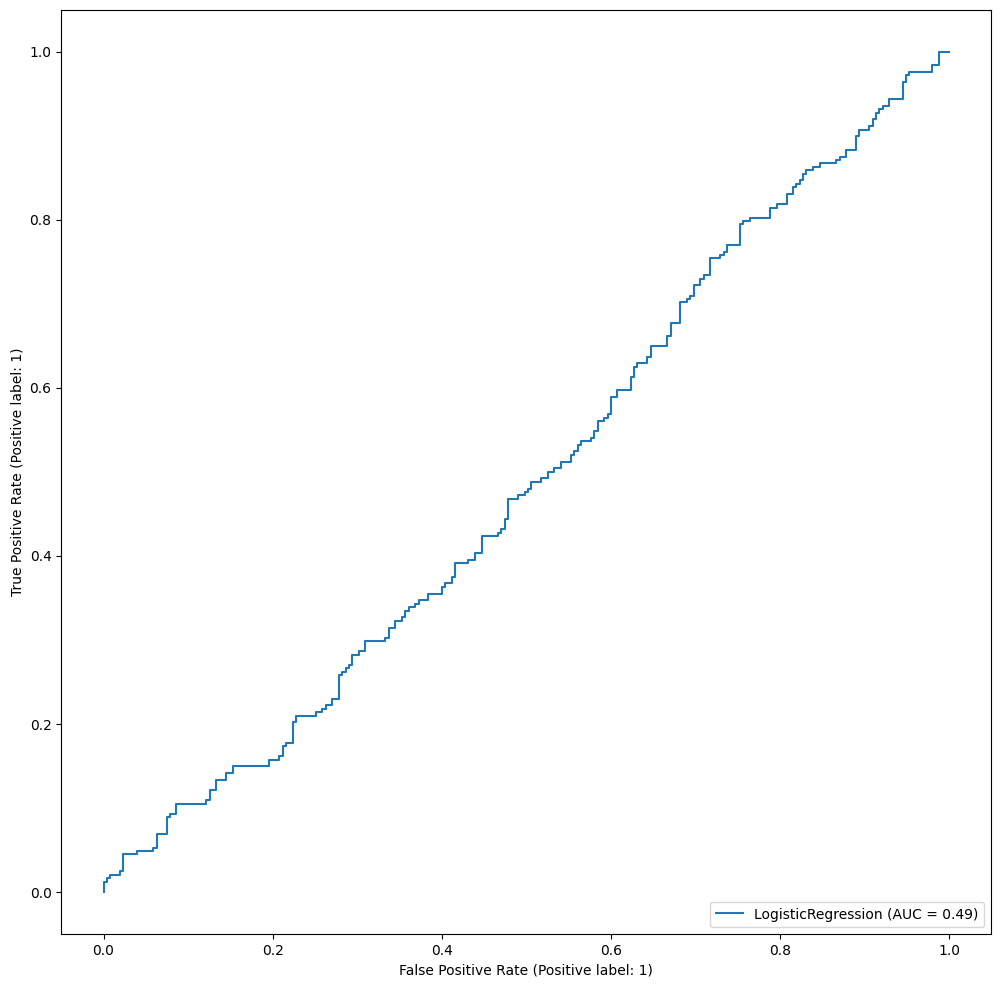

In [93]:
LogReg = LogisticRegression()
LogReg.fit(x_train,y_train)

RocCurveDisplay.from_estimator(LogReg, x_val, y_val)

The Logistic Regression works poorly, we repeat the for the other classifiers

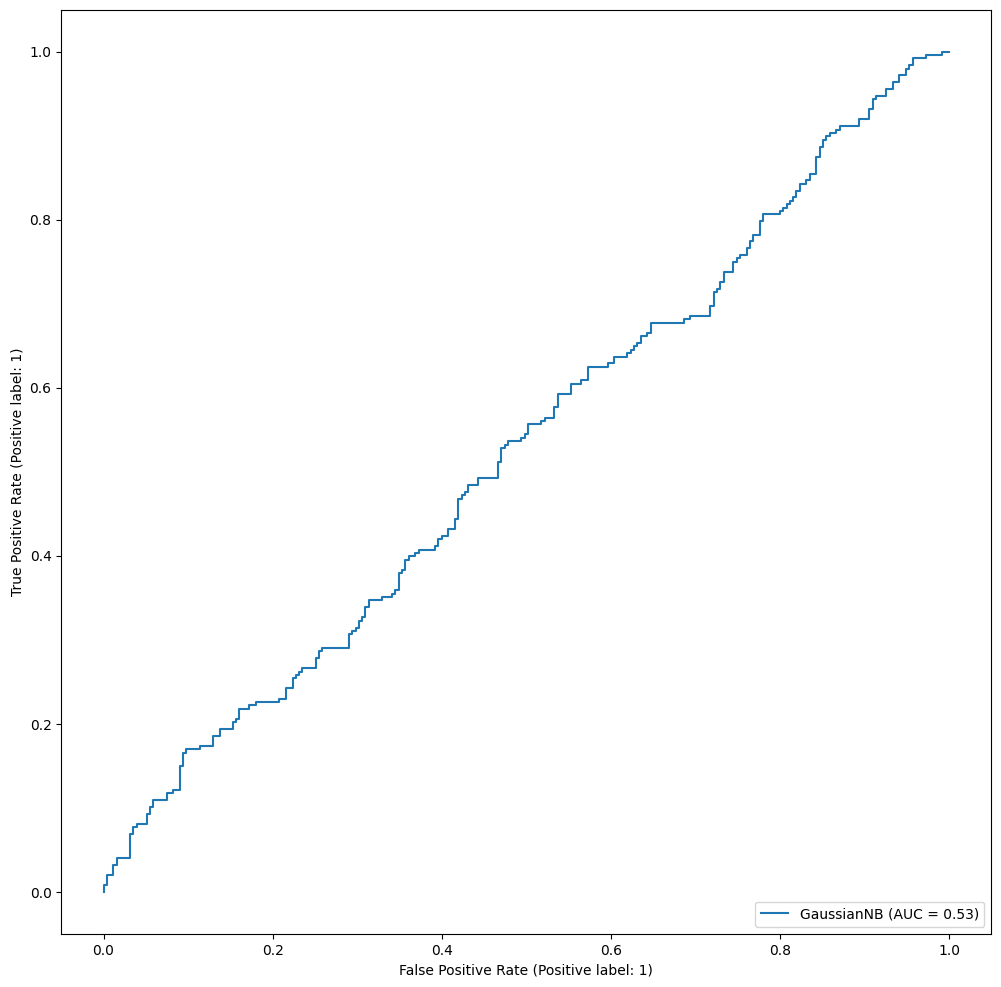

In [94]:
# Naive Bayes Classifier
NB = GaussianNB()
NB.fit(x_train,y_train)
RocCurveDisplay.from_estimator(NB, x_val, y_val)

The Naive Bayes works well, especially for a task of this kind

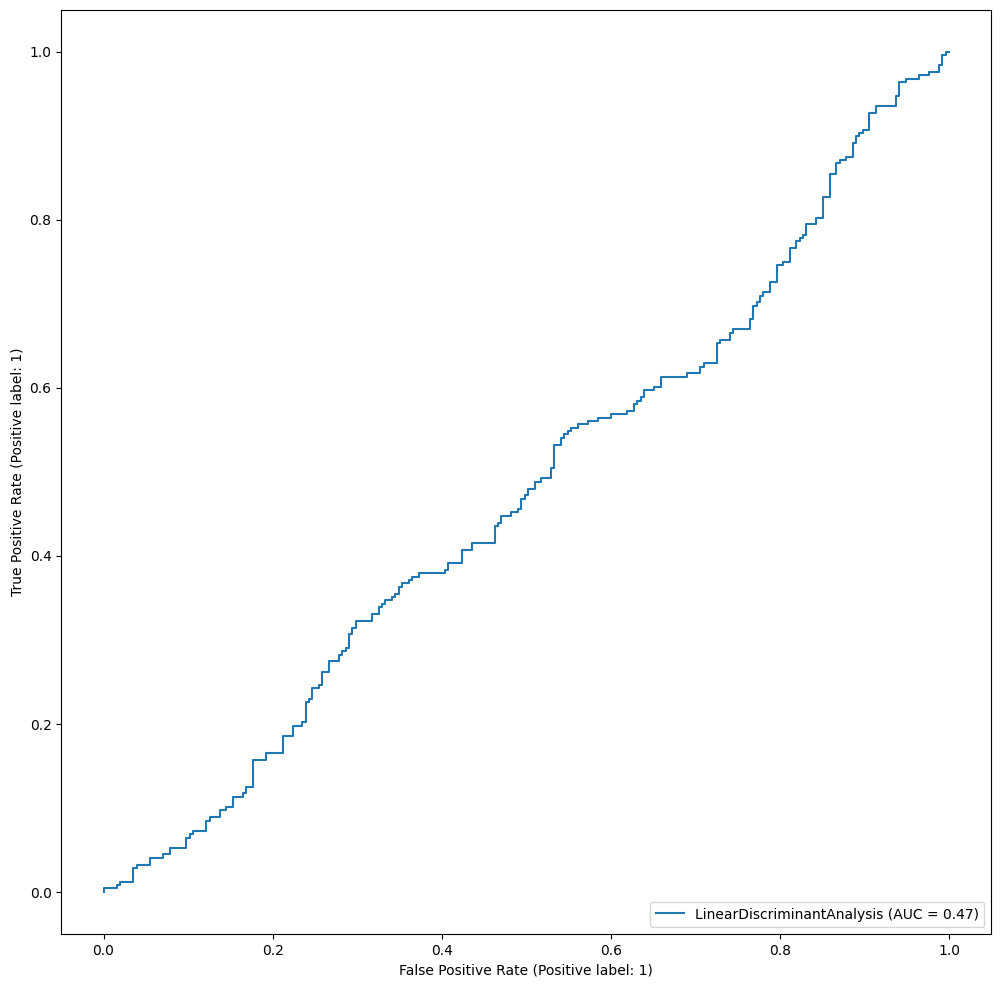

In [95]:
# Linear Discriminant Analysis
FisherLD = LDA()
FisherLD.fit(x_train,y_train)
RocCurveDisplay.from_estimator(FisherLD, x_val, y_val)

Linear Discriminant Analysis performs poorly, we next try quadratic

C:\Users\Navid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


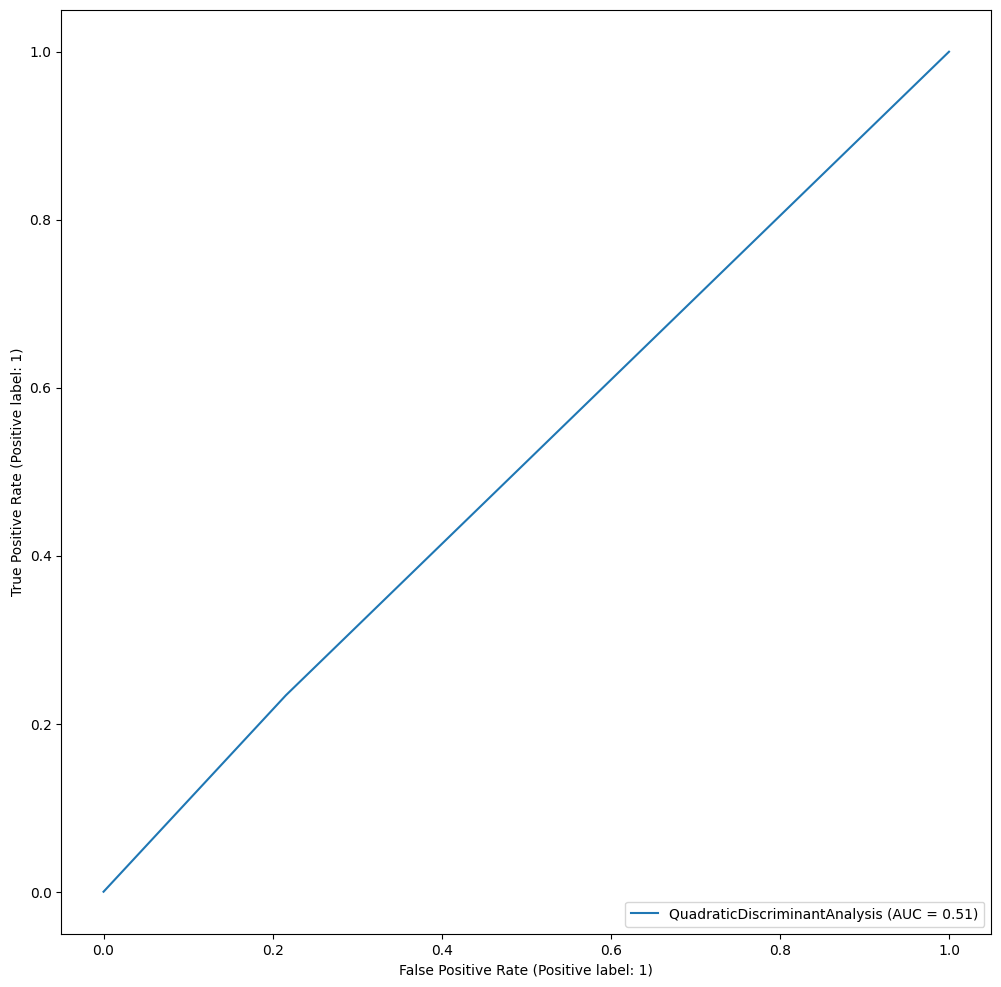

In [96]:
QD = QDA()
QD.fit(x_train,y_train)
RocCurveDisplay.from_estimator(QD, x_val, y_val)

Not too bad, Next we try some ensemble trees, the random forest and boosting. We perform a cross-validated gridsearch for optimal hyperparameters.

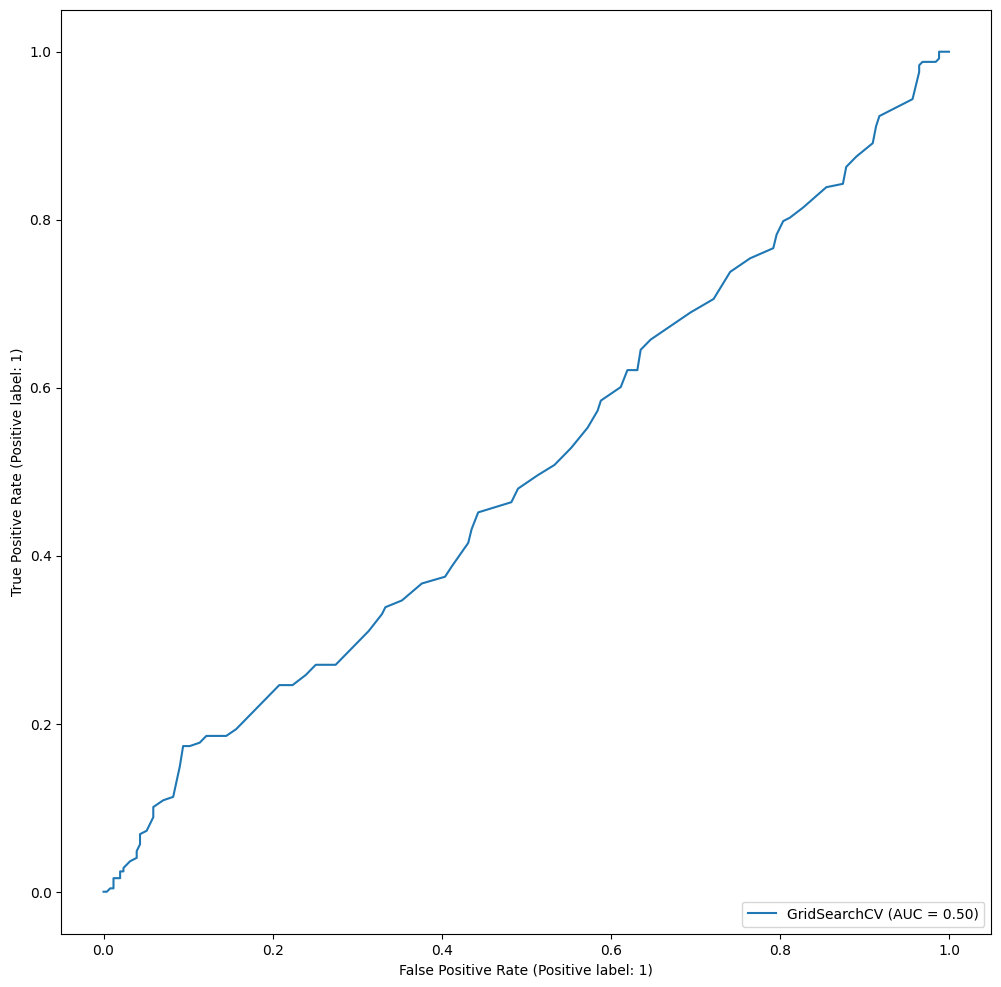

In [97]:
# Runtime should be ~ 4 min for this cell

RF_param_grid = {'n_estimators': [200], 'max_features': [2,3,4,5,6,7,8], 'random_state': [22]} # I like the number 22

RandF = GridSearchCV(RF(),param_grid= RF_param_grid)

RandF.fit(x_train,y_train)

RocCurveDisplay.from_estimator(RandF, x_val, y_val)

Pretty poor, lets try Boosting

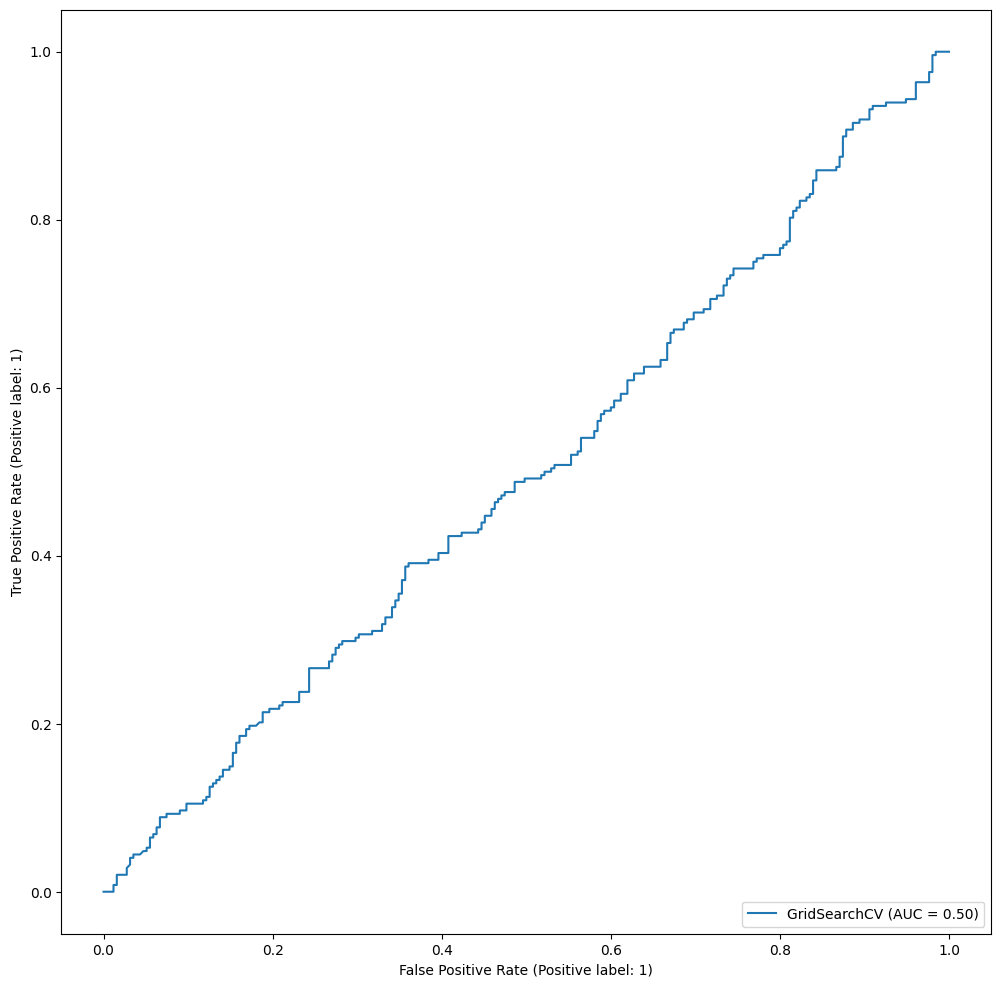

In [98]:
# Runtime should be ~ 2.5 min for this cell

GB_param_grid = {'learning_rate': [0.1,0.01,0.001], 'n_estimators': [100, 500], 'max_depth': [3], 'random_state': [22]} 

Boost = GridSearchCV(GB(), param_grid= GB_param_grid)

Boost.fit(x_train,y_train)


RocCurveDisplay.from_estimator(Boost, x_val, y_val)

Similarly poor performance from boosting

Finally, we try the Support Vector Classifier, with a similar hyperparameter search.

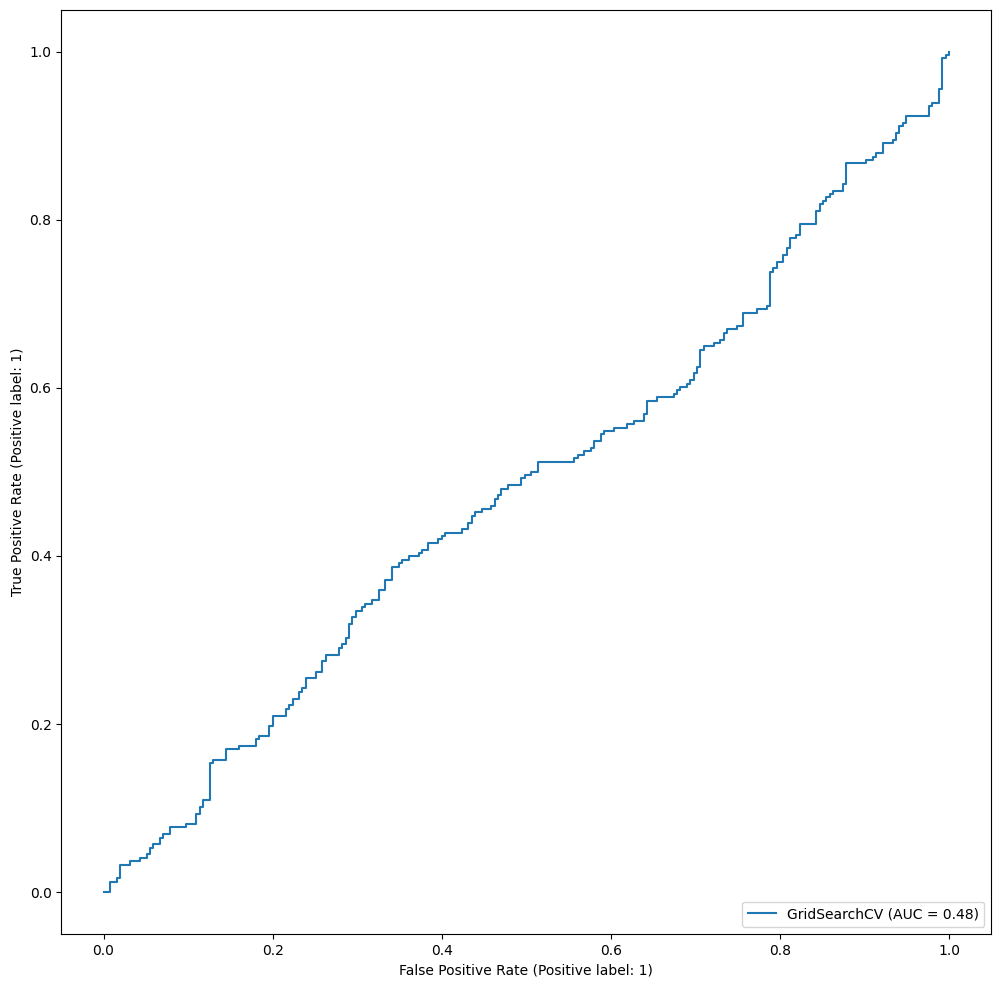

In [99]:
# ~ 3 min runtime

# Requires Feature Scaling

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.fit_transform(x_val)
x_test_scaled = scaler.fit_transform(x_test)

Cs = 10. ** np.arange(-3, 4)
gammas = 10. ** np.arange(-3, 3)


rbf_grid = {'C':Cs, 'gamma':gammas, 'kernel':['rbf']}


SVMachine = GridSearchCV(SVC(),param_grid= rbf_grid)

SVMachine.fit(x_train_scaled,y_train)

RocCurveDisplay.from_estimator(SVMachine, x_val_scaled, y_val)


The Support Vector Classifier performs worse than random guessing! 

Finally, we evaluate the models on the test set

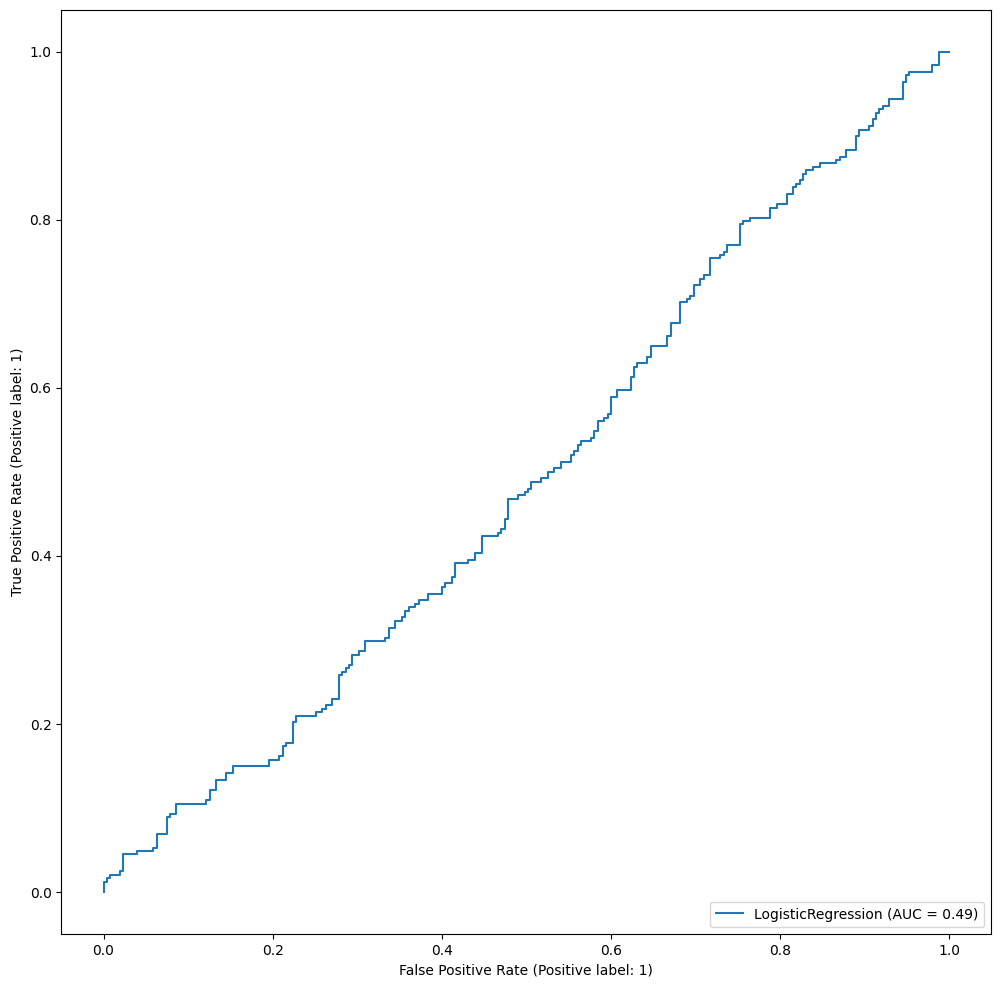

In [100]:
RocCurveDisplay.from_estimator(LogReg, x_test, y_test)

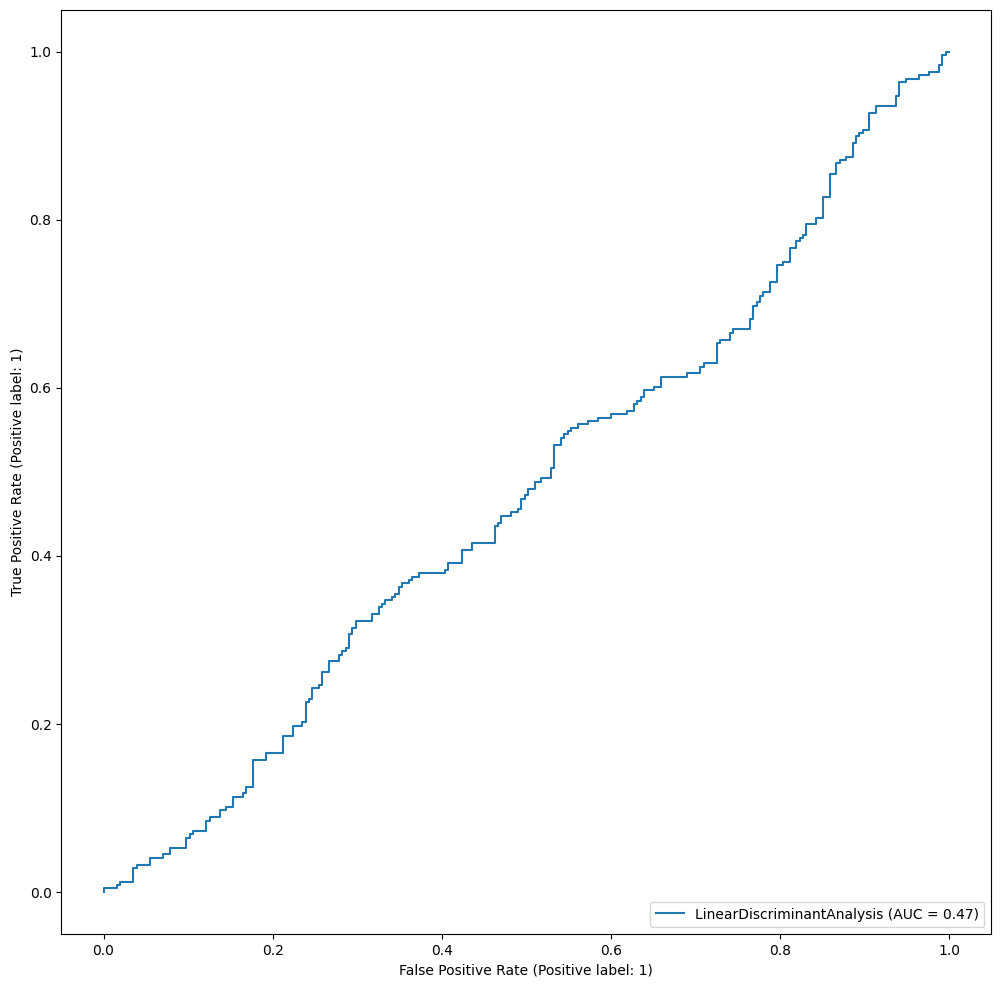

In [101]:
RocCurveDisplay.from_estimator(FisherLD, x_test, y_test)

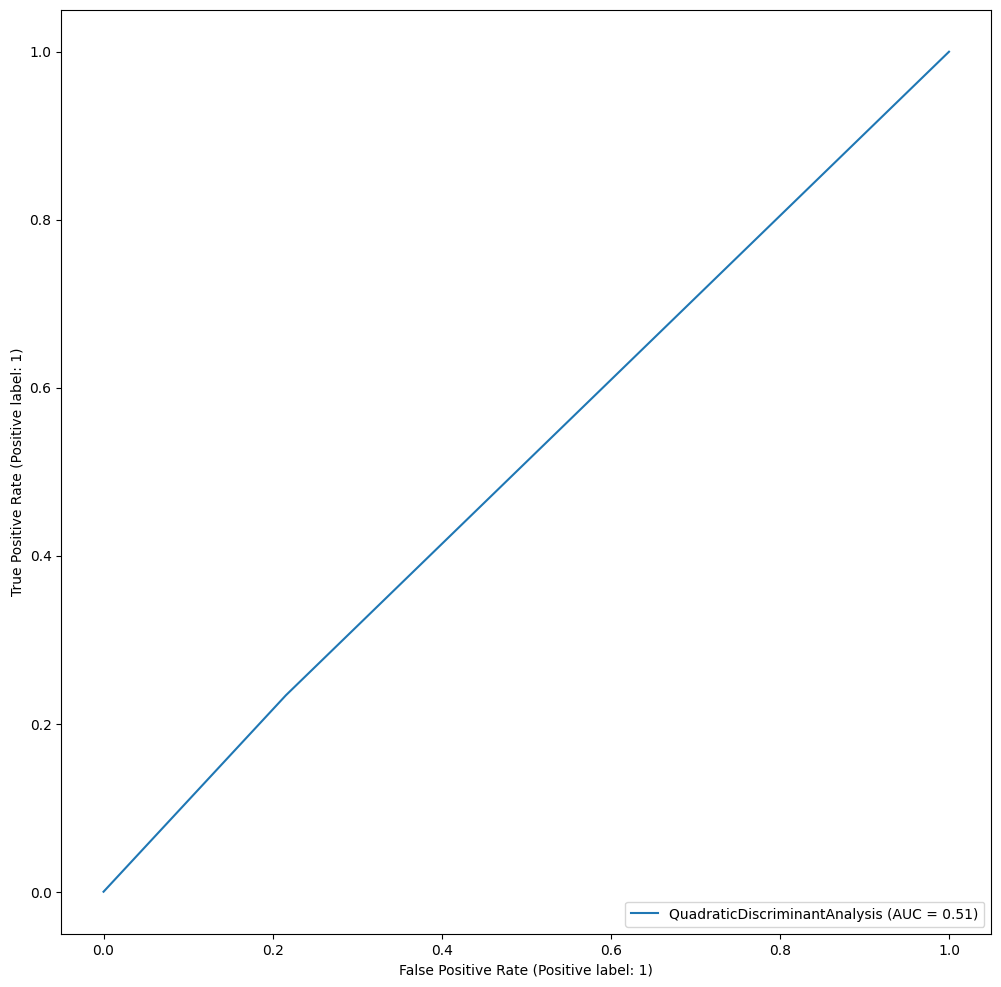

In [102]:
RocCurveDisplay.from_estimator(QD, x_test, y_test)

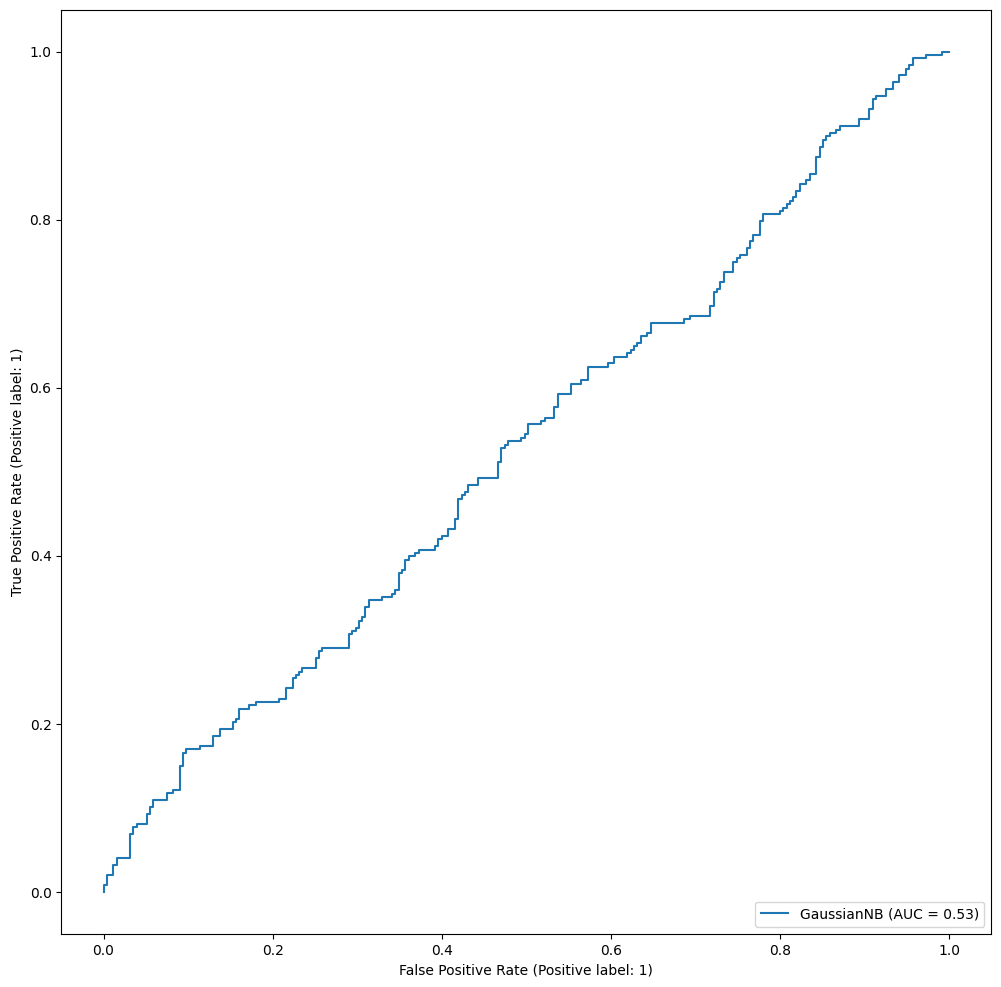

In [103]:
RocCurveDisplay.from_estimator(NB, x_test, y_test)

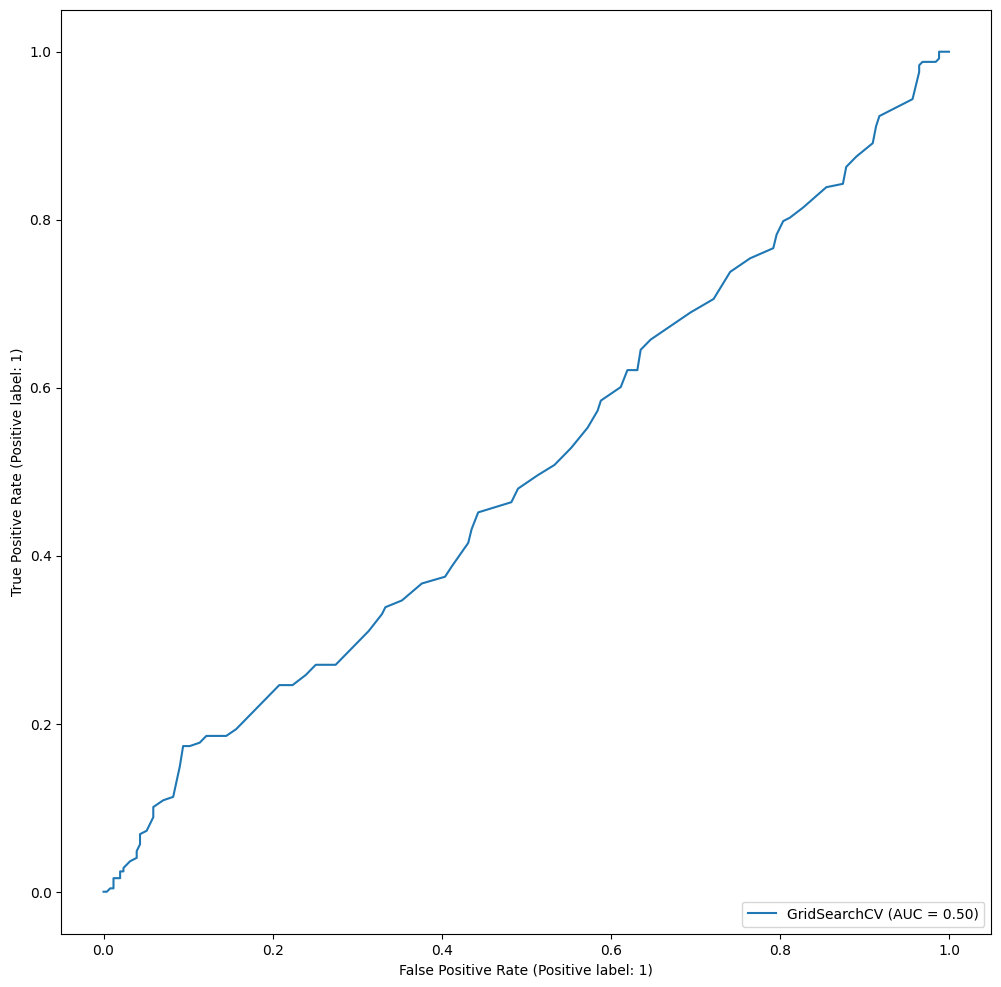

In [104]:
RocCurveDisplay.from_estimator(RandF, x_test, y_test)

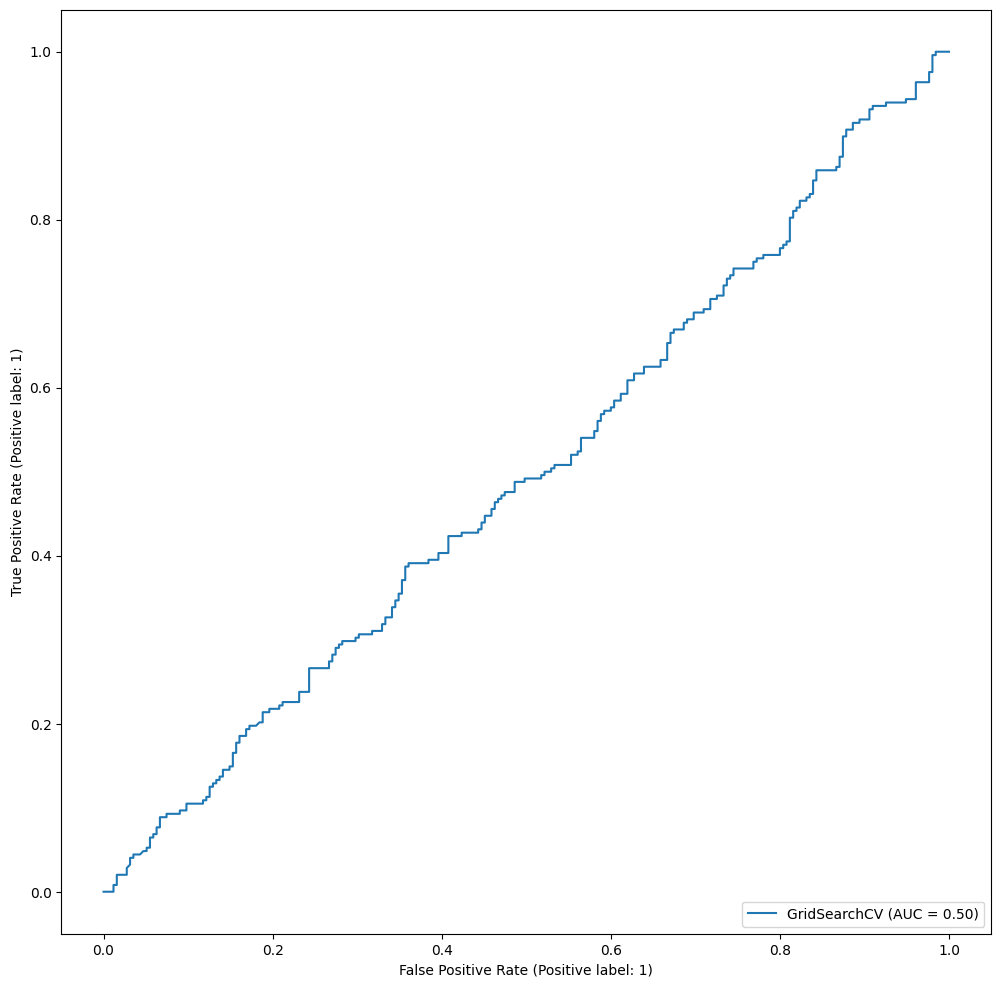

In [105]:
RocCurveDisplay.from_estimator(Boost, x_test, y_test)

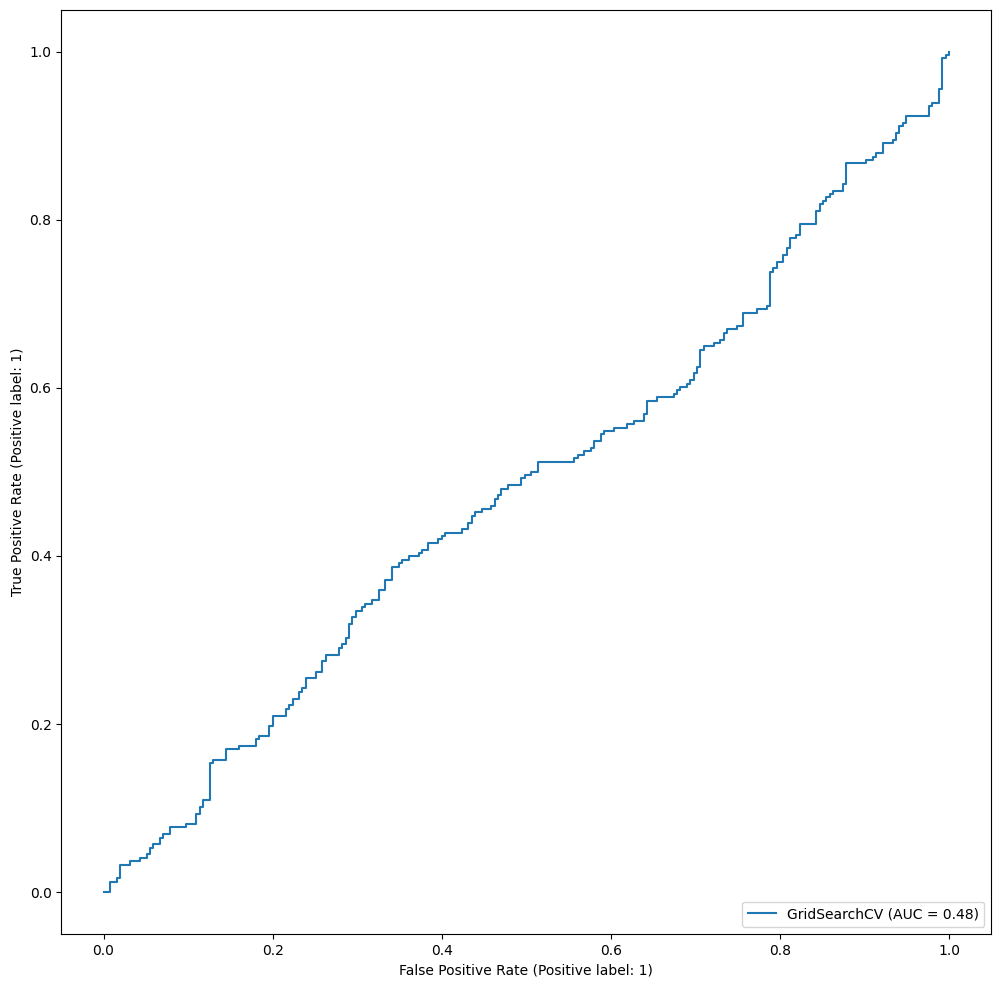

In [106]:
RocCurveDisplay.from_estimator(SVMachine, x_test_scaled, y_test)

The Naive Bayes Classifier continues to perform well, beating our AUC target of 0.515 and earning itself a position as our selected model.